In [3]:
# setting Library
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
mercari_df= pd.read_csv('train.tsv',sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(32432, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


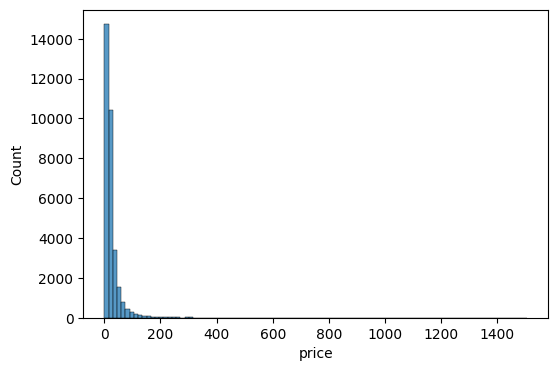

In [4]:
# target label distribution
y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.histplot(y_train_df, bins=100)
plt.show()

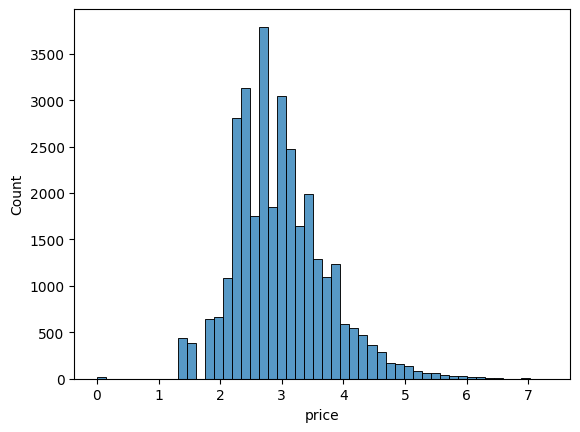

In [5]:
# 데이터가 한 곳에 치우쳤기 때문에 log 변환 후 분포 확인
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=50)
plt.show()

In [6]:
# value Rebalancing
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [7]:
# 1은 판매자 0은 생산자 부담
print('Shipping 값 유형:\n',mercari_df['shipping'].value_counts())
# 제일 좋은 상태의 아이템이 많이 판매됨
print('item_condition_id 값 유형:\n',mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    17925
1    14507
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    14092
3     9426
2     8138
4      714
5       62
Name: item_condition_id, dtype: int64


In [8]:
# 설명서가 없는 아이템 갯수
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()


1808

In [9]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null' , 'Other_Null' , 'Other_Null']

# zip 함수를 통해 여러개를 묶은 다음, 카테고리 이름을 스플릿 한다
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수 :', mercari_df['cat_jung'].nunique())
print('소분류 갯수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     14447
Beauty                     4714
Kids                       3700
Electronics                2729
Men                        2001
Home                       1454
Vintage & Collectibles     1040
Other                       997
Handmade                    650
Sports & Outdoors           539
Other_Null                  161
Name: cat_dae, dtype: int64
중분류 갯수 : 110
소분류 갯수 : 601


In [10]:
# 전처리 하는데 있어 null 값 처리 (Other Null)로 처리
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [11]:
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [12]:
print('brand name 의 유형 건수 :', mercari_df['brand_name'].nunique())
print('brand name sample 5건 : \n', mercari_df['brand_name'].value_counts()[:5])
print('name 의 종류 갯수 :', mercari_df['name'].nunique())
print('name sample 7건 : \n', mercari_df['name'][:7])

brand name 의 유형 건수 : 1277
brand name sample 5건 : 
 Other_Null           13969
PINK                  1189
Nike                  1150
Victoria's Secret     1000
LuLaRoe                665
Name: brand_name, dtype: int64
name 의 종류 갯수 : 31356
name sample 7건 : 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


In [14]:
# 최대 출력 행 갯수 200개로 바꿈
pd.set_option('max_colwidth', 200)
print('item_description 평균 문자열 개수:',mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 개수: 145.8817217562901


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

## 벡터화 및 인코딩 작업

In [16]:
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# tf-idf 설정
## ngram 크기:(1-3)
### stop_words = 영어
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3) , stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

In [19]:
from sklearn.preprocessing import LabelBinarizer

# LabelBinarizer 필요적인 컬럼만 원 핫 인코딩
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])


lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [20]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand_shape:(32432, 1277), X_item_cond_id shape:(32432, 5)
X_shipping shape:(32432, 1), X_cat_dae shape:(32432, 11)
X_cat_jung shape:(32432, 110), X_cat_so shape:(32432, 601)


In [21]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# CSR 형식으로 행렬 보여줌
X_features_sparse= hstack(sparse_matrix_list).tocsr()
# 열이 많이 증가함
print(type(X_features_sparse), X_features_sparse.shape)

<class 'scipy.sparse._csr.csr_matrix'> (32432, 66399)


In [22]:
del X_features_sparse
gc.collect()

16004

In [23]:
def rmsle(y , y_pred):
    # 평가 지표 구축
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

In [24]:
def evaluate_org_price(y_test , preds):
   preds_exmpm = np.expm1(preds)
   y_test_exmpm = np.expm1(y_test)
   rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
   return rmsle_result

In [25]:
import gc
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
  # 가로로 행렬 결합
  X= hstack(matrix_list).tocsr()
  X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'],
                                                      test_size=0.2, random_state=156)
  model.fit(X_train , y_train)
  preds = model.predict(X_test)
  # protect memory
  del X , X_train , X_test , y_train
  gc.collect()

  # 예측 결과만 나옴
  return preds , y_test

## Model Fitting

In [26]:
# 선형 모델
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
# 희소 행렬 화
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)

print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)

print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5704527766920916
Item Description을 포함한 rmsle 값: 0.5566877099487769


In [27]:
!pip install LightGBM

In [28]:
from lightgbm import LGBMRegressor

# 원 핫 인코딩 된 부분
sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 4.067954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 118144
[LightGBM] [Info] Number of data points in the train set: 25945, number of used features: 5311
[LightGBM] [Info] Start training from score 2.971081
LightGBM rmsle 값: 0.6123696514141682


In [29]:
# 앙상블
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.543724763812735
